<a href="https://colab.research.google.com/github/pfauda/python/blob/gh-pages/EstrategiaRSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Estrategia RSI con activos de alta volatilidad

In [37]:
!pip install yfinance
!pip install mplfinance

In [246]:
# Importar librerias
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from mplfinance.original_flavor import candlestick_ohlc
import datetime

In [233]:
# Inicializaciones
tickers = ["GGAL", "BMA", "SUPV", "BBAR"]
#tickers = ["GGAL"]
precios = {} # diccionario para guardar los datos

# Importación de datos
for i in range(len(tickers)):
    precios[tickers[i]] = yf.download(tickers[i], start="2000-01-01") #["Adj Close"].to_frame()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [234]:
precios

{'BBAR':                  Open       High        Low      Close  Adj Close  Volume
 Date                                                                     
 2000-01-03  20.705185  20.979790  20.320738  20.375660  12.223932   99200
 2000-01-04  20.320738  20.320738  19.442003  19.442003  11.663807   63600
 2000-01-05  19.442003  19.771528  19.332161  19.771528  11.861497   41900
 2000-01-06  19.661688  19.991213  19.661688  19.771528  11.861497   41700
 2000-01-07  19.771528  19.826450  19.057558  19.222321  11.532011   64200
 ...               ...        ...        ...        ...        ...     ...
 2021-01-04   3.250000   3.250000   3.000000   3.020000   3.020000  377700
 2021-01-05   2.980000   3.090000   2.960000   2.990000   2.990000  304500
 2021-01-06   3.020000   3.080000   2.970000   2.980000   2.980000  284600
 2021-01-07   3.010000   3.040000   2.910000   2.960000   2.960000  392900
 2021-01-08   3.010000   3.010000   2.900000   2.970000   2.970000  244500
 
 [5289 rows x 6

In [235]:
# Función para cálculo de RSI
def RSI(DF, n, source):
    "función para calcular el RSI"
    df = DF.copy()
    df['diff']= df[source] - df[source].shift(1)
    df['gain']= np.where(df['diff']>=0,df['diff'],0)
    df['loss']= np.where(df['diff']<0,abs(df['diff']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    df['avg_gain']= np.array(avg_gain)
    df['avg_loss']= np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    return df['RSI']

In [236]:
# Cálculo RSI
price_dict = copy.deepcopy(precios)
for ticker in tickers:
    print("Calculando RSI de", ticker)
    price_dict[ticker]["RSI"] = RSI(price_dict[ticker], 14, 'Adj Close')
    price_dict[ticker].dropna(inplace=True)

Calculando RSI de GGAL
Calculando RSI de BMA
Calculando RSI de SUPV
Calculando RSI de BBAR


In [209]:
def plot_chart(data, n, ticker, sobreVenta, sobreCompra):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((18, 7))
    #ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ##ax_macd  = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    #ax_rsi    = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    #ax_vol    = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    ax_candle = fig.add_axes((0, 1.00, 1, 0.50))
    ax_rsi    = fig.add_axes((0, 0.75, 1, 0.20), sharex=ax_candle)
    ax_vol    = fig.add_axes((0, 0.50, 1, 0.20), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    ## Plot candlestick chart
    #ax_candle.plot(data.index, data["ma10"], label="MA10")
    #ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    #ax_candle.legend()
    
    ## Plot MACD
    #ax_macd.plot(data.index, data["macd"], label="macd")
    #ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    #ax_macd.plot(data.index, data["macd_signal"], label="signal")
    #ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [sobreCompra] * len(data.index), label="S.Compra")
    ax_rsi.plot(data.index, [sobreVenta] * len(data.index), label="S.Venta")
    ax_rsi.plot(data.index, data["RSI"], label="RSI")
    ax_rsi.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000000)
    ax_vol.set_ylabel("(En millones)")
   
    # Save the chart as PNG
    #fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
    plt.show()

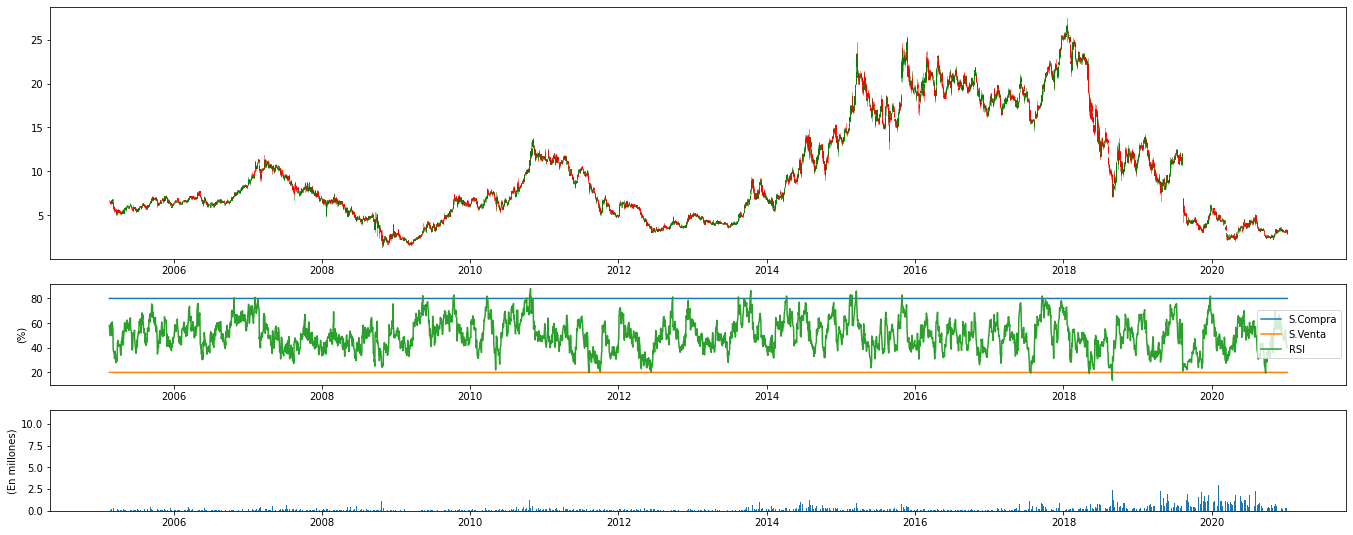

In [219]:
plot_chart(price_dict[ticker], 4000, ticker, 20, 80)

In [211]:
#price_dict["GGAL"]["Signal"] = np.where((price_dict["GGAL"]["RSI"] > 75), "Buy", np.where((price_dict["GGAL"]["RSI"] < 60), "Sell", "none"))

In [252]:
def calc_strategy(data, sobreVenta, sobreCompra, source):

  # Cálculo de strategia y backtesting
  p_compra = 0
  p_venta = 0
  resultado = []
  trades = pd.DataFrame(columns = ['fecha_compra', 'fecha_cierre', 'duracion', 'precio_compra', 'precio_venta', 'resultado'])

  signal = 'neutro'
  for i in range(len(data)):
      if signal == "neutro":
          resultado.append(0)
          if data["RSI"][i]<sobreVenta:
              signal = "comprado"
              fecha_compra = data.index[i] + datetime.timedelta(days=1) #Se supone que compro en el siguiente tick
              p_compra = data['Open'][i+1] #Comprar al precio de apertura del dia siguiente
      elif signal == "comprado":
          resultado.append((data[source][i]/data[source][i-1])-1)
          if data["RSI"][i]>=sobreCompra:
              signal = "neutro"
              fecha_cierre = data.index[i] + datetime.timedelta(days=1) #Se supone que cierro en el siguiente tick
              p_venta = data['Open'][i+1] #Cerrar al precio de apertura del dia siguiente
              d = (data.index[i] - fecha_compra).days
              trades = trades.append({'fecha_compra': fecha_compra,
                                      'fecha_cierre': fecha_cierre,
                                      'duracion': d,
                                      'precio_compra': p_compra,
                                      'precio_venta': p_venta,
                                      'resultado': (p_venta/p_compra-1)},
                                      ignore_index=True)
 
  if signal == "comprado":
    trades = trades.append({'fecha_compra': fecha_compra,
                            'fecha_cierre': float("NAN"),
                            'duracion': float("NAN"),
                            'precio_compra': p_compra,
                            'precio_venta': float("NAN"),
                            'resultado': float("NAN")},
                            ignore_index=True)

  print('\nTrades realizados')
  print("\n",trades)

  data["ret"] = np.array(resultado)
  data["ret_acum"] = (1+data["ret"]).cumprod()

  resultado_prom = trades["resultado"].mean()
  std_res = trades["resultado"].std()
  duracion_prom = trades["duracion"].mean()
  total_trades = len(trades)
  win_trades = len(trades[trades["resultado"]>0])
  loss_trades = len(trades[trades["resultado"]<=0])

  print(f'\nLa ganancia promedio es de {round(resultado_prom*100,2)}%')
  print(f'La desviación estandar del resultado es de {round(std_res*100,2)}%')
  print(f'La duración promedio es de {round(duracion_prom,2)} días')
  print(f'El {round((win_trades/total_trades)*100,2)}% de las veces se sale con ganancias')
  print(f'El {round((loss_trades/total_trades)*100,2)}% de las veces se sale con perdidas')
  print(f'El peor resultado al cierre fue de {round(trades["resultado"].min()*100,2)}%')
  print(f'El mejor resultado al cierre fue de {round(trades["resultado"].max()*100,2)}%')

  print("\nbajas durante la estrategia")
  data["max"] = data["ret_acum"].cummax()
  data["baja"] = data["ret_acum"] / data["max"] -1
  print(f'baja máxima de {round(data["baja"].min()*100,2)}%')

  # RSI Actuales
  print("\nRSI actuales")
  print(round(data["RSI"][-1],2))

In [254]:
for ticker in tickers:
  print("\nCalculando estrategia para ",ticker)
  calc_strategy(price_dict[ticker], 20, 40, "Close")


Calculando estrategia para  GGAL

Trades realizados

   fecha_compra fecha_cierre duracion  precio_compra  precio_venta  resultado
0   2000-08-15   2000-08-24        8      15.562500       15.9375   0.024096
1   2001-07-13   2001-08-10       27      11.500000       10.6500  -0.073913
2   2001-10-05   2001-10-12        6       4.910000        5.7000   0.160896
3   2002-01-18   2002-01-23        4       2.350000        3.4700   0.476596
4   2006-05-23   2006-06-01        8       6.100000        6.4500   0.057377
5   2011-09-23   2011-10-13       19       8.480000        8.9800   0.058962
6   2018-08-30   2018-09-07        7      21.440001       24.5000   0.142724
7   2019-09-04   2019-09-28       23       9.970000       13.1800   0.321966
8   2020-09-22   2020-11-03       41       7.640000        7.1900  -0.058900

La ganancia promedio es de 12.33%
La desviación estandar del resultado es de 17.91%
La duración promedio es de 15.89 días
El 77.78% de las veces se sale con ganancias
El 22.2

In [175]:
#tickers_ret["GGAL"]
#price_dict["GGAL"]
#df_signals = []
#df = np.where((price_dict["GGAL"]["RSI"] > 50), "Buy", np.where((price_dict["GGAL"]["RSI"] > 30), "Sell", ""))
#price_dict["GGAL"]